In [1]:
import sys
import pip
import re, numpy as np, pandas as pd
from pprint import pprint
import json
import collections
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import  simple_preprocess
from gensim.models import CoherenceModel, Word2Vec
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import ssl

In [2]:
stop_words = stopwords.words('english')
stop_words.extend(['people','morning','amp','https','http','co','from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [3]:
def read_data():
    #return pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
    return pd.read_json(open("nonGeoLondonJan","r",encoding="utf"),lines=True)

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent) 
        
def quick_process(sent):
    sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
    sent = re.sub('\s+', ' ', sent)  # remove newline chars        sent = re.sub("\'", "", sent)  # remove single quotes
    sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
    return sent 

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN','PROPN']):
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []

    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

def train_model():
    df = pd.read_json(open("TrainData","r",encoding="utf"),lines=True)
    data = df.text.values.tolist()
    data_words = list(sent_to_words(data))
    model = gensim.models.Word2Vec(data_words, min_count=1)
    return model

In [4]:
df = read_data()

top_tweets={}
outlier_tweets={}

#List the top tweeting usershttp://localhost:8888/notebooks/OneDrive%20-%20University%20of%20Glasgow/University%20Year%203/Web%20Science/Coursework%20Files/Coursework%20Q2.ipynb#
top_tweeters = df.groupby('username').size().sort_values(ascending=False).to_frame()
top_tweeters.columns = ['count']

In [5]:
model = train_model()    

In [6]:
#Empty dict of users with 3 or more tweets
for x in top_tweeters.iterrows():
    if x[1].tolist()[0] >=3:
        top_tweets[x[0]]=""
    else:
        outlier_tweets[x[0]]=""


    
#For top tweeting users group tweets into single document, else group separately
for index, row in df.iterrows():
    username=row['username']
    text=row['text']
    if username in top_tweets.keys():
        top_tweets[username]+=text
    else:
        outlier_tweets[username]+=text

In [7]:
#Convert dict back into pandas data frame
top_df = pd.DataFrame.from_dict(top_tweets, orient='index')
top_df.columns = ['text']

low_df = pd.DataFrame.from_dict(outlier_tweets, orient='index')
low_df.columns = ['text']


top_data = top_df.text.values.tolist()
low_data = low_df.text.values.tolist()

top_data_words = list(sent_to_words(top_data))
low_data_words = list(sent_to_words(low_data))

In [8]:
bigram = gensim.models.Phrases(top_data_words+low_data_words, min_count=20, threshold=8.0) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[top_data_words+low_data_words], threshold=8.0)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [9]:
top_data_ready = process_words(top_data_words)
low_data_ready = process_words(low_data_words)

In [10]:
model_vocab = set(model.wv.index_to_key)

In [11]:
def similarity_score(top_tweet,low_tweet):
    top_words = [w for w in top_tweet if w in model_vocab]
    low_words = [w for w in low_tweet if w in model_vocab]
    if len(top_words)==0 or len(low_words)==0:
        return 0
    else:
        return model.wv.n_similarity(top_words,low_words)
        
    
def find_most_similar(low_tweet):
    max_index=0
    max_score=0
    for i in range(len(top_data_ready)):
        score=similarity_score(set(top_data_ready[i]),set(low_tweet))
        if score>max_score:
            max_score=score
            max_index=i
    return i

In [12]:
i=0
print(len(low_data_ready))
for tweet in low_data_ready:
    print(i/len(low_data_ready)*100,"%")
    i+=1
    index=find_most_similar(tweet)
    top_data_ready[index]=top_data_ready[index]+tweet

6672
0.0 %
0.014988009592326138 %
0.029976019184652276 %
0.04496402877697842 %
0.05995203836930455 %
0.0749400479616307 %
0.08992805755395684 %
0.10491606714628297 %
0.1199040767386091 %
0.13489208633093525 %
0.1498800959232614 %
0.16486810551558753 %
0.1798561151079137 %
0.19484412470023982 %
0.20983213429256595 %
0.22482014388489208 %
0.2398081534772182 %
0.2547961630695444 %
0.2697841726618705 %
0.28477218225419665 %
0.2997601918465228 %
0.3147482014388489 %
0.32973621103117506 %
0.34472422062350117 %
0.3597122302158274 %
0.3747002398081535 %
0.38968824940047964 %
0.40467625899280574 %
0.4196642685851319 %
0.434652278177458 %
0.44964028776978415 %
0.4646282973621103 %
0.4796163069544364 %
0.49460431654676257 %
0.5095923261390888 %
0.5245803357314149 %
0.539568345323741 %
0.5545563549160671 %
0.5695443645083933 %
0.5845323741007195 %
0.5995203836930456 %
0.6145083932853717 %
0.6294964028776978 %
0.644484412470024 %
0.6594724220623501 %
0.6744604316546763 %
0.6894484412470023 %
0.7044

6.025179856115108 %
6.040167865707434 %
6.05515587529976 %
6.070143884892086 %
6.085131894484412 %
6.100119904076739 %
6.115107913669065 %
6.130095923261391 %
6.145083932853717 %
6.160071942446043 %
6.175059952038369 %
6.190047961630695 %
6.205035971223022 %
6.220023980815348 %
6.235011990407674 %
6.25 %
6.264988009592326 %
6.279976019184652 %
6.294964028776978 %
6.309952038369304 %
6.32494004796163 %
6.339928057553957 %
6.3549160671462825 %
6.36990407673861 %
6.384892086330936 %
6.399880095923262 %
6.414868105515588 %
6.429856115107914 %
6.44484412470024 %
6.459832134292566 %
6.474820143884892 %
6.4898081534772185 %
6.504796163069544 %
6.51978417266187 %
6.534772182254196 %
6.549760191846523 %
6.5647482014388485 %
6.579736211031174 %
6.594724220623502 %
6.609712230215828 %
6.624700239808154 %
6.63968824940048 %
6.654676258992806 %
6.669664268585132 %
6.684652278177458 %
6.6996402877697845 %
6.71462829736211 %
6.729616306954436 %
6.744604316546762 %
6.759592326139089 %
6.77458033573141

12.125299760191846 %
12.140287769784171 %
12.155275779376499 %
12.170263788968825 %
12.185251798561152 %
12.200239808153478 %
12.215227817745804 %
12.23021582733813 %
12.245203836930456 %
12.260191846522781 %
12.275179856115107 %
12.290167865707433 %
12.30515587529976 %
12.320143884892087 %
12.335131894484412 %
12.350119904076738 %
12.365107913669064 %
12.38009592326139 %
12.395083932853717 %
12.410071942446043 %
12.425059952038369 %
12.440047961630697 %
12.455035971223023 %
12.470023980815348 %
12.485011990407674 %
12.5 %
12.514988009592326 %
12.529976019184652 %
12.544964028776977 %
12.559952038369303 %
12.574940047961631 %
12.589928057553957 %
12.604916067146283 %
12.619904076738608 %
12.634892086330934 %
12.64988009592326 %
12.664868105515586 %
12.679856115107913 %
12.69484412470024 %
12.709832134292565 %
12.724820143884893 %
12.73980815347722 %
12.754796163069546 %
12.769784172661872 %
12.784772182254198 %
12.799760191846524 %
12.81474820143885 %
12.829736211031175 %
12.8447242206

18.075539568345324 %
18.09052757793765 %
18.10551558752998 %
18.120503597122305 %
18.13549160671463 %
18.150479616306956 %
18.165467625899282 %
18.180455635491608 %
18.195443645083934 %
18.21043165467626 %
18.225419664268586 %
18.24040767386091 %
18.255395683453237 %
18.270383693045563 %
18.28537170263789 %
18.300359712230215 %
18.31534772182254 %
18.330335731414866 %
18.345323741007196 %
18.36031175059952 %
18.375299760191847 %
18.390287769784173 %
18.4052757793765 %
18.420263788968825 %
18.43525179856115 %
18.450239808153476 %
18.465227817745802 %
18.480215827338128 %
18.495203836930454 %
18.51019184652278 %
18.525179856115106 %
18.540167865707435 %
18.55515587529976 %
18.570143884892087 %
18.585131894484412 %
18.600119904076738 %
18.615107913669064 %
18.630095923261393 %
18.64508393285372 %
18.660071942446045 %
18.67505995203837 %
18.690047961630697 %
18.705035971223023 %
18.72002398081535 %
18.735011990407674 %
18.75 %
18.764988009592326 %
18.77997601918465 %
18.794964028776977 %
1

24.040767386091126 %
24.055755395683455 %
24.07074340527578 %
24.085731414868107 %
24.100719424460433 %
24.11570743405276 %
24.130695443645084 %
24.14568345323741 %
24.160671462829736 %
24.175659472422062 %
24.190647482014388 %
24.205635491606714 %
24.22062350119904 %
24.235611510791365 %
24.25059952038369 %
24.265587529976017 %
24.280575539568343 %
24.29556354916067 %
24.310551558752998 %
24.325539568345324 %
24.34052757793765 %
24.35551558752998 %
24.370503597122305 %
24.38549160671463 %
24.400479616306956 %
24.415467625899282 %
24.430455635491608 %
24.445443645083934 %
24.46043165467626 %
24.475419664268586 %
24.49040767386091 %
24.505395683453237 %
24.520383693045563 %
24.53537170263789 %
24.550359712230215 %
24.56534772182254 %
24.580335731414866 %
24.595323741007196 %
24.61031175059952 %
24.625299760191847 %
24.640287769784173 %
24.6552757793765 %
24.670263788968825 %
24.68525179856115 %
24.700239808153476 %
24.715227817745802 %
24.730215827338128 %
24.745203836930454 %
24.760191

30.00599520383693 %
30.020983213429258 %
30.035971223021583 %
30.05095923261391 %
30.065947242206235 %
30.080935251798564 %
30.09592326139089 %
30.110911270983216 %
30.125899280575542 %
30.140887290167868 %
30.155875299760194 %
30.17086330935252 %
30.185851318944845 %
30.20083932853717 %
30.215827338129497 %
30.230815347721823 %
30.24580335731415 %
30.260791366906474 %
30.2757793764988 %
30.290767386091126 %
30.305755395683455 %
30.32074340527578 %
30.335731414868107 %
30.350719424460433 %
30.36570743405276 %
30.380695443645084 %
30.39568345323741 %
30.410671462829736 %
30.425659472422062 %
30.440647482014388 %
30.455635491606714 %
30.47062350119904 %
30.485611510791365 %
30.50059952038369 %
30.515587529976017 %
30.530575539568343 %
30.54556354916067 %
30.560551558752998 %
30.575539568345324 %
30.59052757793765 %
30.605515587529975 %
30.6205035971223 %
30.635491606714627 %
30.650479616306953 %
30.66546762589928 %
30.680455635491604 %
30.69544364508393 %
30.710431654676256 %
30.72541966

36.061151079136685 %
36.076139088729015 %
36.09112709832134 %
36.106115107913666 %
36.121103117505996 %
36.13609112709832 %
36.15107913669065 %
36.16606714628298 %
36.1810551558753 %
36.19604316546763 %
36.21103117505996 %
36.22601918465228 %
36.24100719424461 %
36.25599520383693 %
36.27098321342926 %
36.28597122302158 %
36.30095923261391 %
36.315947242206235 %
36.330935251798564 %
36.34592326139089 %
36.360911270983216 %
36.37589928057554 %
36.39088729016787 %
36.40587529976019 %
36.42086330935252 %
36.43585131894484 %
36.45083932853717 %
36.4658273381295 %
36.48081534772182 %
36.49580335731415 %
36.510791366906474 %
36.525779376498804 %
36.540767386091126 %
36.555755395683455 %
36.57074340527578 %
36.58573141486811 %
36.60071942446043 %
36.61570743405276 %
36.63069544364508 %
36.64568345323741 %
36.66067146282973 %
36.67565947242206 %
36.69064748201439 %
36.705635491606714 %
36.72062350119904 %
36.735611510791365 %
36.750599520383695 %
36.76558752997602 %
36.780575539568346 %
36.7955

42.17625899280576 %
42.19124700239808 %
42.20623501199041 %
42.22122302158273 %
42.23621103117506 %
42.25119904076738 %
42.26618705035971 %
42.281175059952034 %
42.29616306954436 %
42.311151079136685 %
42.326139088729015 %
42.34112709832134 %
42.356115107913666 %
42.371103117505996 %
42.38609112709832 %
42.40107913669065 %
42.41606714628298 %
42.4310551558753 %
42.44604316546763 %
42.46103117505996 %
42.47601918465228 %
42.49100719424461 %
42.50599520383693 %
42.52098321342926 %
42.53597122302158 %
42.55095923261391 %
42.565947242206235 %
42.580935251798564 %
42.59592326139089 %
42.610911270983216 %
42.62589928057554 %
42.64088729016787 %
42.65587529976019 %
42.67086330935252 %
42.68585131894484 %
42.70083932853717 %
42.7158273381295 %
42.73081534772182 %
42.74580335731415 %
42.760791366906474 %
42.775779376498804 %
42.790767386091126 %
42.805755395683455 %
42.82074340527578 %
42.83573141486811 %
42.85071942446043 %
42.86570743405276 %
42.88069544364508 %
42.89568345323741 %
42.9106714

48.26139088729017 %
48.27637889688249 %
48.29136690647482 %
48.30635491606714 %
48.32134292565947 %
48.336330935251794 %
48.351318944844124 %
48.36630695443645 %
48.381294964028775 %
48.396282973621105 %
48.41127098321343 %
48.42625899280576 %
48.44124700239808 %
48.45623501199041 %
48.47122302158273 %
48.48621103117506 %
48.50119904076738 %
48.51618705035971 %
48.531175059952034 %
48.54616306954436 %
48.561151079136685 %
48.576139088729015 %
48.59112709832134 %
48.606115107913666 %
48.621103117505996 %
48.63609112709832 %
48.65107913669065 %
48.66606714628298 %
48.6810551558753 %
48.69604316546763 %
48.71103117505996 %
48.72601918465228 %
48.74100719424461 %
48.75599520383693 %
48.77098321342926 %
48.78597122302158 %
48.80095923261391 %
48.815947242206235 %
48.830935251798564 %
48.84592326139089 %
48.860911270983216 %
48.87589928057554 %
48.89088729016787 %
48.90587529976019 %
48.92086330935252 %
48.93585131894484 %
48.95083932853717 %
48.9658273381295 %
48.98081534772182 %
48.9958033

54.36151079136691 %
54.376498800959226 %
54.39148681055156 %
54.40647482014388 %
54.421462829736214 %
54.43645083932853 %
54.451438848920866 %
54.466426858513195 %
54.48141486810552 %
54.49640287769785 %
54.51139088729017 %
54.5263788968825 %
54.54136690647482 %
54.55635491606715 %
54.57134292565947 %
54.5863309352518 %
54.601318944844124 %
54.61630695443645 %
54.631294964028775 %
54.646282973621105 %
54.66127098321343 %
54.67625899280576 %
54.69124700239808 %
54.706235011990415 %
54.72122302158273 %
54.73621103117507 %
54.75119904076738 %
54.76618705035972 %
54.781175059952034 %
54.79616306954437 %
54.811151079136685 %
54.82613908872902 %
54.84112709832134 %
54.85611510791367 %
54.871103117505996 %
54.886091127098325 %
54.90107913669065 %
54.91606714628298 %
54.9310551558753 %
54.94604316546763 %
54.96103117505995 %
54.97601918465228 %
54.9910071942446 %
55.00599520383693 %
55.020983213429254 %
55.03597122302158 %
55.050959232613906 %
55.065947242206235 %
55.08093525179856 %
55.095923

60.446642685851316 %
60.461630695443645 %
60.47661870503597 %
60.4916067146283 %
60.50659472422062 %
60.52158273381295 %
60.53657074340527 %
60.5515587529976 %
60.56654676258992 %
60.58153477218225 %
60.596522781774574 %
60.61151079136691 %
60.626498800959226 %
60.64148681055156 %
60.65647482014388 %
60.671462829736214 %
60.68645083932853 %
60.701438848920866 %
60.716426858513195 %
60.73141486810552 %
60.74640287769785 %
60.76139088729017 %
60.7763788968825 %
60.79136690647482 %
60.80635491606715 %
60.82134292565947 %
60.8363309352518 %
60.851318944844124 %
60.86630695443645 %
60.881294964028775 %
60.896282973621105 %
60.91127098321343 %
60.92625899280576 %
60.94124700239808 %
60.956235011990415 %
60.97122302158273 %
60.98621103117507 %
61.00119904076738 %
61.01618705035972 %
61.031175059952034 %
61.04616306954437 %
61.061151079136685 %
61.07613908872902 %
61.09112709832134 %
61.10611510791367 %
61.121103117505996 %
61.136091127098325 %
61.15107913669065 %
61.16606714628298 %
61.181055

66.59172661870504 %
66.60671462829735 %
66.62170263788968 %
66.63669064748201 %
66.65167865707434 %
66.66666666666666 %
66.681654676259 %
66.69664268585132 %
66.71163069544365 %
66.72661870503596 %
66.7416067146283 %
66.75659472422062 %
66.77158273381295 %
66.78657074340528 %
66.80155875299761 %
66.81654676258992 %
66.83153477218225 %
66.84652278177458 %
66.86151079136691 %
66.87649880095923 %
66.89148681055156 %
66.90647482014388 %
66.92146282973621 %
66.93645083932853 %
66.95143884892086 %
66.96642685851319 %
66.98141486810552 %
66.99640287769785 %
67.01139088729016 %
67.0263788968825 %
67.04136690647482 %
67.05635491606715 %
67.07134292565947 %
67.08633093525181 %
67.10131894484412 %
67.11630695443645 %
67.13129496402878 %
67.14628297362111 %
67.16127098321343 %
67.17625899280576 %
67.19124700239809 %
67.20623501199042 %
67.22122302158273 %
67.23621103117506 %
67.25119904076739 %
67.26618705035972 %
67.28117505995203 %
67.29616306954436 %
67.31115107913669 %
67.32613908872902 %
67.3

72.81175059952038 %
72.82673860911271 %
72.84172661870504 %
72.85671462829735 %
72.87170263788968 %
72.88669064748201 %
72.90167865707434 %
72.91666666666666 %
72.931654676259 %
72.94664268585132 %
72.96163069544365 %
72.97661870503596 %
72.9916067146283 %
73.00659472422062 %
73.02158273381295 %
73.03657074340528 %
73.05155875299761 %
73.06654676258992 %
73.08153477218225 %
73.09652278177458 %
73.11151079136691 %
73.12649880095923 %
73.14148681055156 %
73.15647482014388 %
73.17146282973621 %
73.18645083932853 %
73.20143884892086 %
73.21642685851319 %
73.23141486810552 %
73.24640287769785 %
73.26139088729016 %
73.2763788968825 %
73.29136690647482 %
73.30635491606715 %
73.32134292565947 %
73.33633093525181 %
73.35131894484412 %
73.36630695443645 %
73.38129496402878 %
73.39628297362111 %
73.41127098321343 %
73.42625899280576 %
73.44124700239809 %
73.45623501199042 %
73.47122302158273 %
73.48621103117506 %
73.50119904076739 %
73.51618705035972 %
73.53117505995203 %
73.54616306954436 %
73.5

79.04676258992805 %
79.06175059952038 %
79.07673860911271 %
79.09172661870504 %
79.10671462829735 %
79.12170263788968 %
79.13669064748201 %
79.15167865707434 %
79.16666666666666 %
79.181654676259 %
79.19664268585132 %
79.21163069544365 %
79.22661870503596 %
79.2416067146283 %
79.25659472422062 %
79.27158273381295 %
79.28657074340528 %
79.30155875299761 %
79.31654676258992 %
79.33153477218225 %
79.34652278177458 %
79.36151079136691 %
79.37649880095923 %
79.39148681055156 %
79.40647482014388 %
79.42146282973621 %
79.43645083932853 %
79.45143884892086 %
79.46642685851319 %
79.48141486810552 %
79.49640287769785 %
79.51139088729016 %
79.5263788968825 %
79.54136690647482 %
79.55635491606715 %
79.57134292565947 %
79.58633093525181 %
79.60131894484412 %
79.61630695443645 %
79.63129496402878 %
79.64628297362111 %
79.66127098321343 %
79.67625899280576 %
79.69124700239809 %
79.70623501199042 %
79.72122302158273 %
79.73621103117506 %
79.75119904076739 %
79.76618705035972 %
79.78117505995203 %
79.7

85.25179856115108 %
85.2667865707434 %
85.28177458033574 %
85.29676258992805 %
85.31175059952038 %
85.32673860911271 %
85.34172661870504 %
85.35671462829735 %
85.37170263788968 %
85.38669064748201 %
85.40167865707434 %
85.41666666666666 %
85.431654676259 %
85.44664268585132 %
85.46163069544365 %
85.47661870503596 %
85.4916067146283 %
85.50659472422062 %
85.52158273381295 %
85.53657074340528 %
85.55155875299761 %
85.56654676258992 %
85.58153477218225 %
85.59652278177458 %
85.61151079136691 %
85.62649880095923 %
85.64148681055156 %
85.65647482014388 %
85.67146282973621 %
85.68645083932853 %
85.70143884892086 %
85.71642685851319 %
85.73141486810552 %
85.74640287769785 %
85.76139088729016 %
85.7763788968825 %
85.79136690647482 %
85.80635491606715 %
85.82134292565947 %
85.83633093525181 %
85.85131894484412 %
85.86630695443645 %
85.88129496402878 %
85.89628297362111 %
85.91127098321343 %
85.92625899280576 %
85.94124700239809 %
85.95623501199042 %
85.97122302158273 %
85.98621103117506 %
86.00

91.4568345323741 %
91.47182254196643 %
91.48681055155875 %
91.50179856115108 %
91.5167865707434 %
91.53177458033574 %
91.54676258992805 %
91.56175059952038 %
91.57673860911271 %
91.59172661870504 %
91.60671462829735 %
91.62170263788968 %
91.63669064748201 %
91.65167865707434 %
91.66666666666666 %
91.681654676259 %
91.69664268585132 %
91.71163069544365 %
91.72661870503596 %
91.7416067146283 %
91.75659472422062 %
91.77158273381295 %
91.78657074340528 %
91.80155875299761 %
91.81654676258992 %
91.83153477218225 %
91.84652278177458 %
91.86151079136691 %
91.87649880095923 %
91.89148681055156 %
91.90647482014388 %
91.92146282973621 %
91.93645083932853 %
91.95143884892086 %
91.96642685851319 %
91.98141486810552 %
91.99640287769785 %
92.01139088729016 %
92.0263788968825 %
92.04136690647482 %
92.05635491606715 %
92.07134292565947 %
92.08633093525181 %
92.10131894484412 %
92.11630695443645 %
92.13129496402878 %
92.14628297362111 %
92.16127098321343 %
92.17625899280576 %
92.19124700239809 %
92.206

97.66187050359713 %
97.67685851318944 %
97.69184652278177 %
97.7068345323741 %
97.72182254196643 %
97.73681055155875 %
97.75179856115108 %
97.7667865707434 %
97.78177458033574 %
97.79676258992805 %
97.81175059952038 %
97.82673860911271 %
97.84172661870504 %
97.85671462829735 %
97.87170263788968 %
97.88669064748201 %
97.90167865707434 %
97.91666666666666 %
97.931654676259 %
97.94664268585132 %
97.96163069544365 %
97.97661870503596 %
97.9916067146283 %
98.00659472422062 %
98.02158273381295 %
98.03657074340528 %
98.05155875299761 %
98.06654676258992 %
98.08153477218225 %
98.09652278177458 %
98.11151079136691 %
98.12649880095923 %
98.14148681055156 %
98.15647482014388 %
98.17146282973621 %
98.18645083932853 %
98.20143884892086 %
98.21642685851319 %
98.23141486810552 %
98.24640287769785 %
98.26139088729016 %
98.2763788968825 %
98.29136690647482 %
98.30635491606715 %
98.32134292565947 %
98.33633093525181 %
98.35131894484412 %
98.36630695443645 %
98.38129496402878 %
98.39628297362111 %
98.411

In [13]:
print(len(top_data_ready))
print(len(low_data_ready))
length=[len(x) for x in top_data_ready]
print(sum(length)/len(length))
print(max(length))

1330
6672
50.10225563909774
36783


In [14]:
# Create Dictionary
id2word = corpora.Dictionary(top_data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in top_data_ready]

In [15]:
coherence = []
for n in range(2,18):
    print("Topic",n)
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=n, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=1000,
                                               passes=20,
                                               alpha='auto',
                                               #iterations=200,
                                               per_word_topics=True)
    cm = gensim.models.coherencemodel.CoherenceModel(model=lda_model,
                                                    texts=top_data_ready,
                                                    dictionary=id2word,
                                                    coherence='c_v')
    coherence.append((n,cm.get_coherence()))
    


Topic 2
Topic 3
Topic 4
Topic 5
Topic 6


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (16,) and (4,)

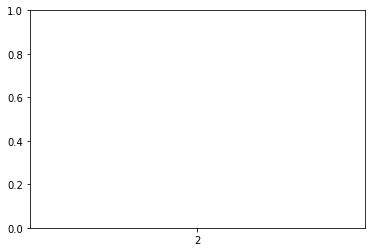

In [16]:
x, y = zip(*coherence)
x = [str(i) for i in range(2,18)]
    
plt.plot(x,y,'xb-')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

In [17]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                           num_topics=9, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10000,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)


In [18]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=top_data_ready):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=top_data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9997,"rule, crime, law, violation, humanity, atrocit...","[champion, human_right, violation, dictator, r..."
1,1,8.0,0.9990,"bottomlessdeal, brunch, time, nft, life, party...","[nation, king, hotel, ur, publife, brunch, shi..."
2,2,4.0,0.9991,"edujobs, book, thing, london, school, day, tim...","[evaluation, impact, lead, child, society, loc..."
3,3,5.0,0.9913,"still_heya, man, dad, thing, player, team, mas...","[measures_since, measures_since, thing, measur..."
4,4,1.0,0.9969,"rule, crime, law, violation, humanity, atrocit...","[golf, event, weekend, watch, sport, rory, loa..."
...,...,...,...,...,...
1325,1325,8.0,0.9664,"bottomlessdeal, brunch, time, nft, life, party...","[photo, date, united_fan, criminal, ronaldo, g..."
1326,1326,2.0,0.9655,"wordle, day, time, today, love, man, thing, ye...","[domestic_abuse, angle, case, complexity, just..."
1327,1327,8.0,0.7670,"bottomlessdeal, brunch, time, nft, life, party...",[shitwordle]
1328,1328,2.0,0.9936,"wordle, day, time, today, love, man, thing, ye...","[moment, kindle, night, row, finish, irene, ou..."


In [19]:
df_dominant_topic['Topic_Perc_Contrib'].mean()

0.9243883

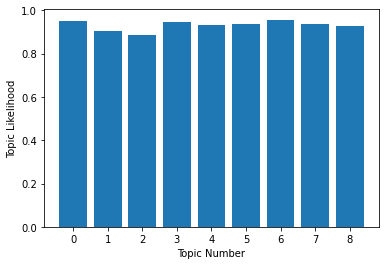

0.93153805


In [22]:
x=['0','1','2','3','4','5','6','7','8']
y=[]
for i in range(9):
    y.append(df_dominant_topic[df_dominant_topic['Dominant_Topic']==i]['Topic_Perc_Contrib'].mean())
plt.bar(x,y)
plt.xlabel("Topic Number")
plt.ylabel("Topic Likelihood")
plt.show()
print(np.mean(y))

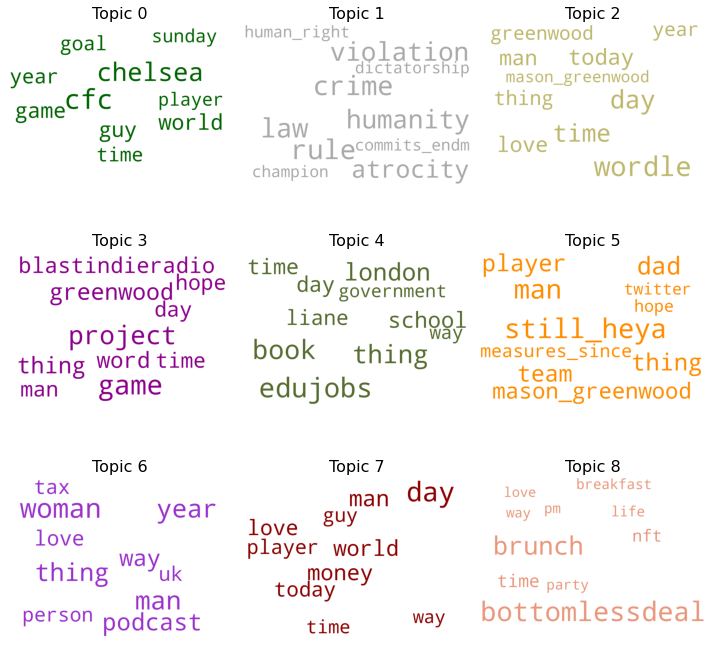

In [21]:
# 1. Wordcloud of Top N words in each topic

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
cols = [color for name, color in list(mcolors.CSS4_COLORS.items())[25:50]]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_topics=21,formatted=False)



fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)


for i, ax in enumerate(axes.flatten()):

    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [31]:
for text in df_dominant_topic[df_dominant_topic['Dominant_Topic']==0]['Text']:
    print(text,"\n")

['chelsea', 'point', 'thomas', 'tuchel', 'international', 'break', 'cbd', 'vzw', 'xc', 'cfc', 'ktbffhfrank', 'shock', 'everton', 'decision', 'gift', 'thomas', 'tuchel', 'chelsea', 'premier_league', 'bonus', 'lkebtteubl', 'cfc', 'ktbffhmalang', 'sarr', 'matchday', 'ritual', 'zoc', 'cfc', 'ktbffhhow', 'frank_lampard', 'tottenham', 'race', 'place', 'vmf', 'wwxv', 'cfc', 'ktbffhwomen', 'match', 'report', 'aston', 'villa', 'chelsea', 'vgoxtrdunk', 'cfc', 'ktbffhchelsea', 'coach', 'club', 'premier_league', 'rival', 'cfc', 'ktbffhalvaro', 'morata', 'transfer', 'warning', 'tottenham', 'antonio', 'conte', 'verdict', 'ldlkknnyaj', 'cfc', 'ktbffhchelsea', 'statement', 'transfer', 'ncdmdf', 'jre', 'cfc', 'ktbffhthomas', 'tuchel', 'chelsea', 'game', 'changer', 'premier_league', 'switch', 'ogallntmuf', 'cfc', 'ktbffhplaymaker', 'van', 'der', 'vaart', 'chelsea', 'star', 'ideal', 'attacking', 'partner', 'harry', 'kane', 'oy', 'svgh', 'cfc', 'ktbffhousmane', 'dembele', 'chelsea', 'transfer', 'edge', 'b

In [35]:
cm = gensim.models.coherencemodel.CoherenceModel(model=lda_model,
                                                texts=top_data_ready,
                                                dictionary=id2word,
                                                coherence='c_v')

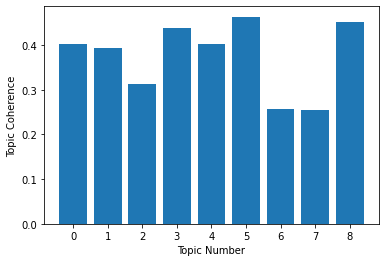

In [36]:
x=['0','1','2','3','4','5','6','7','8']
y=cm.get_coherence_per_topic()
plt.bar(x,y)
plt.xlabel("Topic Number")
plt.ylabel("Topic Coherence")
plt.show()